In [1]:
# !nvidia-smi -L

In [2]:
# !pip install albumentations
# !pip install tensorflow
# !pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [3]:
# # Google Drive mounting
# from google.colab import drive
# drive.mount('/content/drive')

# GDRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/SF_Projects/module_7'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools, glob

import PIL
from PIL import Image

import albumentations as A

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import *

from IPython.display import clear_output
from tqdm import trange, tqdm

!pip freeze > requirements.txt
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# %load_ext tensorboard

# Import Data

- поначалу проект выполнялся на Google Colab
\
$\to$ [ноутбук](https://colab.research.google.com/drive/1Ufvu4pOIz0MwczaM2AbBlBEIv1mIctBD?usp=sharing)

In [5]:
# # for Google Colab
# # downloading files from the mentor's bucket (to the current directory)
# !gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
# # unpacking all archives
# !unzip -o sf-dl-car-classification.zip && rm sf-dl-car-classification.zip
# !unzip -q -o sf-dl-car-classification/"*.zip" -d sf-dl-car-classification && rm sf-dl-car-classification/*.zip

### Working directories

In [6]:
# setting the path to working directories
# DATA_PATH = '/content/sf-dl-car-classification/' # Google Colab
DATA_PATH = 'data'
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test_upload')

# Вспомогательные функции

In [7]:
# Функция для отображения примеров из генератора

def show_first_images(generator, count=5, labels=True, figsize=(15, 5), normalized=False):
    generator = itertools.islice(generator, count)
    fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
    for batch, ax in zip(generator, axes):
        if labels:
            img_batch, labels_batch = batch
            img, label = img_batch[0], np.argmax(labels_batch[0])
        else:
            img_batch = batch
            img = img_batch[0]
        if not normalized:
            img = img.astype(np.uint8)
        ax.imshow(img)
        if labels:
            ax.set_title(f'Class: {label}')
    plt.show()

# EDA

1. Посмотрим на **train dataset**
   - всего - 15561 изображений
   - количество классов - 10
   - распределение достаточно равномерное


2. Посмотрим на примеры изображений и их размеры

   - изображения разного размера (в основном 640х480), встречаются как горизонтальной так и вертикальной ориентации
   - часто на фоне target'а встречаются "посторонние" авто относящихся к другому классу; есть авто не относящиеся к классу `car`; присутствуют логотипы торговых площадок & etc.
  \
  $\to$ (_см. Data cleaning_) кропним target'ы и отсеем фото с не `car` (выбросы). Для этого используем предубоченую модель из `GluonCV model_zoo`
     - модель `center_net_resnet50_v1b_voc` выбрана в первую очередь из-за скорости работы\
     (в среднем 1.24 секунды на картинку (итерацию) $\to$ не разобрался какая модель использует GPU, чтобы ускорить процесс)
     - качество распознавания приемлемо, хотя встречаются излишне (неточно) обрезанные
     \
     $\to$ проводить дополнительный _tuning модели_ не будем (да и не умею)
     - Отсеяно - 2596 изображений
     \
     $\to$ подозреваю, что среди отсеяных много _false negative_, хотелось бы использовать более продвинутую модель с более высоким _mAP_, но они в разы медленее 

In [8]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'sample-submission.csv'))

display(train_df.sample(5), test_df.sample(5))

,Id,Category
4702,251125.jpg,2
2709,205505.jpg,1
2686,203191.jpg,1
6470,280862.jpg,3
4734,25573.jpg,2


,Id,Category
4719,299615.jpg,0
1124,298123.jpg,0
2639,58133.jpg,0
6184,48506.jpg,0
586,77903.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


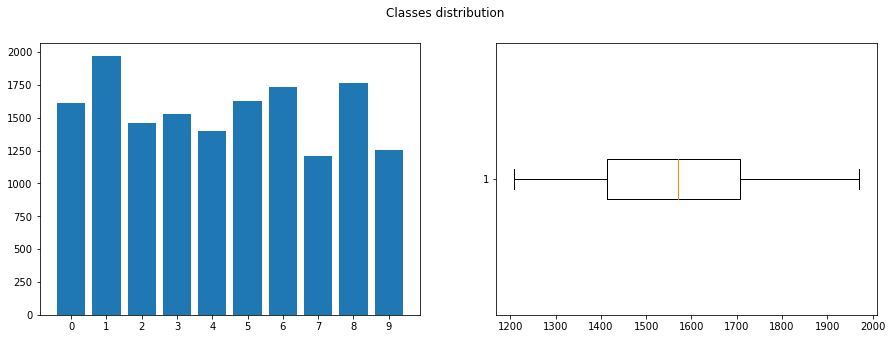

In [10]:
# смотрим распределение классов
classes_dist = train_df['Category'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(classes_dist.index, classes_dist.values)
axs[0].set_xticks(classes_dist.index)
axs[1].boxplot(classes_dist, vert=False)
fig.suptitle('Classes distribution');

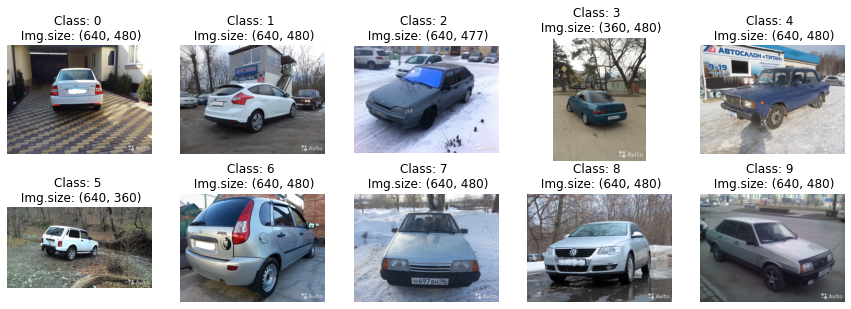

In [11]:
# смотрим random sample image из каждого класса и image size
classes_num = train_df['Category'].nunique()

plt.figure(figsize=(15,5))

for i in range(classes_num):
    file_name = train_df[train_df['Category']==i].sample(1)['Id'].iloc[0]
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, str(i), file_name))
    plt.subplot(2, classes_num//2, i+1)
    plt.imshow(img)
    plt.title(f"Class: {i} \n Img.size: {img.size}")
    plt.axis('off')
plt.show()

In [12]:
# имена классов
class_names = {0:'LADA Priora',
               1:'Ford Focus',
               2:'LADA 2114',
               3:'LADA 2110',
               4:'LADA 2107',
               5:'NIVA',
               6:'LADA Kalina',
               7:'LADA 2109',
               8:'VW Passat',
               9:'LADA 21099'}

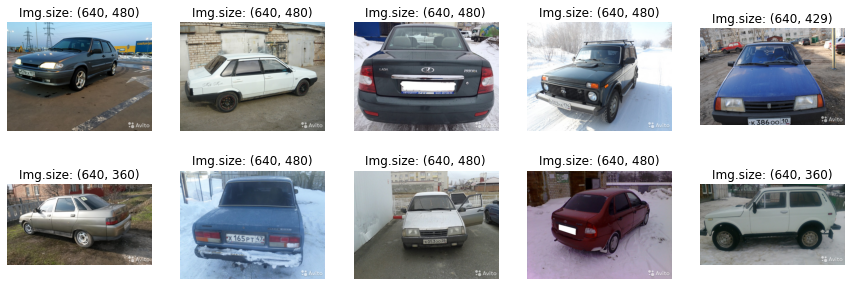

In [13]:
plt.figure(figsize=(15,5))

for i in range(classes_num):
    file_name = test_df.sample(1)['Id'].iloc[0]
    img = PIL.Image.open(os.path.join(TEST_IMG_PATH, file_name))
    plt.subplot(2, classes_num//2, i+1)
    plt.imshow(img)
    plt.title(f"Img.size: {img.size}")
    plt.axis('off')
plt.show()

# Data cleaning

- Обработка фотографии заняла около 5 часов
\
$\to$ сделаем backup на Google Drive
   - [Cropped test images](https://drive.google.com/drive/folders/1NMccOLEZ6wSfelAUMm3whv5Mh_zMzOPj?usp=sharing)
   - [Cropped train images](https://drive.google.com/drive/folders/10GsF5XwjRVSwXS6xlO1-2QNog2wHYs0e?usp=sharing)
\
$\to$ далее будем подгружать фото из Google Drive


- Идея оказалась нежизнеспособной: средняя точность на валидации 40-50% против 70-80% с некропнутыми изображениями\
(__См. удаленный код в `Module-7_[Addon]_Getting_Cropped_Image.ipynb`__)
\
$\to$ возможные причины (_предположение_):
    - изображения становятся сильно отличными от _ImageNet_
    - слишком большой разброс _ppi_ и влияние "артефактов" сжатия т.к. "мелкие" таргеты были слишком сильно увеличены
    - было ошибочно удалено слишком большое количество изображений одного из классов

# Augmentation

- Для аугментации будем использовать `ImageDataGenerator + Albumentations`
\
$\to$ (off-top) Хотелось найти способ сохранить соотношение сторон картинки при прохождении через `from_dataframe(target_size)`, но выяснилось, что данный функционал все еще в разработке с 2018 года

In [14]:
# Presets

BATCH_SIZE = 32

IMG_SIZE   = 224

VAL_SIZE   = 0.2

In [15]:
# задаем набор преобразований в виде функции для передачи в ImageDataGenerator(preprocessing_function)
def augmentations(image):
    image = image.astype(np.uint8)
    transform = A.Compose([# geometry changes
                           A.HorizontalFlip(p=0.5),
                           A.ShiftScaleRotate(p=0.75,
                                              shift_limit=(-0.0625, 0.0625),
                                              scale_limit=(-0.1, 0.1),
                                              rotate_limit=(-20, 20),
                                              interpolation=1,
                                              border_mode=4),
                           # color changes
#                            A.CLAHE(p=0.5),
                           A.OneOf([A.HueSaturationValue(p=1),
                                    A.ChannelShuffle(p=1),
                                    A.RGBShift(p=1)],
                                   p=0.5),
                           A.RandomBrightnessContrast(p=0.5)])
  
    return transform(image=image)['image']

In [16]:
'''
Error: If class_mode="categorical", y_col="Category"
column values must be type string, list or tuple
'''
# заменим int на str
train_df['Category'] = train_df['Category'].apply(lambda x: str(x))

In [17]:
# Generator: Делит датасет на обучающий и валидационный в пропорции 80% и 20% соответственно

datagen = ImageDataGenerator(validation_split=VAL_SIZE,
                             preprocessing_function=augmentations)

# Data loader for training subset
train_generator = datagen.flow_from_directory(directory=TRAIN_IMG_PATH,
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=RANDOM_SEED,
                                              subset='training')

# Data loader for validation subset
val_generator = datagen.flow_from_directory(directory=TRAIN_IMG_PATH,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True,
                                            seed=RANDOM_SEED,
                                            subset='validation')

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


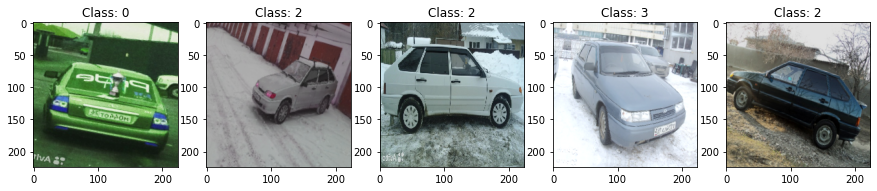

In [18]:
# посмотрим на результат
show_first_images(train_generator)

# Training

## Model

- Сходу берем модель `EfficientNet` показывающую лучшие результаты (по обзору результатов лидеров соревнования). Версия `B5` из соображений хорошей скорости работы (Images per second)
\
$\to$ из-за траблов с Google Colab перешел на локальный ПК и с удивлением обнаружил, что на нем расчет проходит намного быстрее $\to$ перешел на версию `B6`


- берем архитектуру "головы" которую часто используют в проектах с _EfficientNet_ и лидеры данного соревнования
\
$\to$ для эксперимента попробовал "голову" с одним полносвязным слоем (как в исходной модели (_EfficientNetB5_) - результат хуже 
    - Модель близка к переобучению
    \
    $\to$ Model 2
      - уменьшим patience для ReduceLROnPlateau (уберем ограничение минимального значения LR, оставленное по невнимательности)
      - добавим L2 регуляризацию полносвязных слоев

    $\to$ Model 3
      - добавим регуляризацию (BatchNormalization & Dropout) и перед первым полносвязным слоем
      \
      $\to$ судя по графикам `loss` и `accuracy` кажется нащупал вариант архитектуры головы который не приводит к переобучению. Однако видно, что 50 эпох недостаточно и есть потенциал к росту точности (нет времени считать больше эпох)

    $\to$ Model 4
      - попробуем увеличить LR для первых эпох и добавим `LR Schedule` для снижения LR к более поздним эпохам\
      $\to$ ~на ровном месте вылезла ошибка которую я не смог одолеть~
      \
      $\to$ изменение LR очень хорошо сказалось на сходимости - получили почти идеальный график `epoch vs loss`
      \
      $\to$ модель не доучена - 25 эпох маловато 
      - попробовал увеличить размер входного изображения (528x528x3 - т.е. размер изображений (дефолтный) на которых обучалась базовая модель _EfficientNetB6_) - точность сильно лучше уже на первой эпохе, но расчет требует очень много времени (которого уже нет)


- Возьмём `Model 4` для `Fine tuning`

***[Логи всех моделей](https://drive.google.com/drive/folders/1RARgjxwCx8D7onFk3bBcrj9LKGyEAxDn?usp=sharing)***

In [19]:
# settings
TRY             = 4 # номер модели

MODEL           = 'EfficientNetB6'

CLASSES_NUM     = classes_num

IMG_CHANNELS    = 3
INPUT_SHAPE     = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

EPOCHS          = 25
LEARNING_RATE   = 1e-4
DROPOUT_RATE    = 0.25

STEPS_PER_EPOCH = 12452//BATCH_SIZE
LRS = ExponentialDecay(initial_learning_rate=0.0009, decay_steps=STEPS_PER_EPOCH*3, decay_rate=0.9)
OPT = Adam(LRS)

In [20]:
# preparing the directories
CHECKPOINT_PATH = os.path.join(DATA_PATH, 'chekpoints', MODEL+'_'+str(TRY))

try:
    os.mkdir(CHECKPOINT_PATH)
except OSError:
    pass

LOG_PATH = os.path.join(CHECKPOINT_PATH, 'logs')

try:
    os.mkdir(LOG_PATH)
except OSError:
    pass

In [21]:
# setting the callbacks list
CALLBACKS = [ModelCheckpoint(filepath=os.path.join(CHECKPOINT_PATH, '{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max'),
             EarlyStopping(monitor='val_loss',
                           patience=EPOCHS//4),
             TerminateOnNaN(),
#              ReduceLROnPlateau(monitor='val_loss',
#                                factor=0.1,
#                                patience=EPOCHS//10,
#                                verbose=1),
             TensorBoard(log_dir=LOG_PATH, histogram_freq=1)]

In [22]:
# loading the base model
base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE)
# Freezing all layers of the base model
base_model.trainable = False

In [23]:
# base_model.summary()

In [24]:
# setting the new "head" of model
baseline_model=Sequential()
baseline_model.add(base_model)
baseline_model.add(GlobalAveragePooling2D())
baseline_model.add(BatchNormalization())
baseline_model.add(Dropout(rate=DROPOUT_RATE))
baseline_model.add(Dense(256, activation='relu',
                         kernel_regularizer=l2(0.001)))
baseline_model.add(BatchNormalization())
baseline_model.add(Dropout(rate=DROPOUT_RATE))
baseline_model.add(Dense(CLASSES_NUM, activation='softmax',
                         kernel_regularizer=l2(0.001)))

In [25]:
# compiling and training of model
baseline_model.compile(loss='categorical_crossentropy',
                       optimizer=OPT,
                       metrics=['accuracy'])

In [26]:
# baseline_model.summary()

In [27]:
# history = baseline_model.fit(train_generator,
#                              validation_data=val_generator,
#                              batch_size=BATCH_SIZE,
#                              epochs=EPOCHS,
#                              callbacks=CALLBACKS)

$\uparrow$ ***fit отключен для рестарта kernel***

In [28]:
# %load_ext tensorboard
# # %reload_ext tensorboard
# %tensorboard --logdir "data\chekpoints\EfficientNetB6_4\logs"

$\uparrow$ ***отображение tensorboard отключено для рестарта kernel, так как на Windows есть проблемы с кэшированием***

In [29]:
# # Results of Model 1
# %tensorboard dev upload --logdir \
#     'data\chekpoints\EfficientNetB6\logs'

In [30]:
# # Results of Model 2
# %tensorboard dev upload --logdir \
#     'data\chekpoints\EfficientNetB6_2\logs'

In [31]:
# # Results of Model 3
# %tensorboard dev upload --logdir \
#     'data\chekpoints\EfficientNetB6_3\logs'

In [32]:
# # Results of Model 4
# %tensorboard dev upload --logdir \
#     'data\chekpoints\EfficientNetB6_4\logs'

# Fine tuning

### Step 1

Defrost a half of the pre-trained model weights

$\to$ Понизил Batch size (=16), чтобы влезло в видеопамять

In [33]:
# Frozen model
best_model = '24-0.83.hdf5'

# compile path to the model
BEST_MODEL_PATH = os.path.join(CHECKPOINT_PATH, best_model)

# making a list with paths to the best models for ensemble
models4ensemble = []
# adding the path to list
models4ensemble.append(BEST_MODEL_PATH)

In [34]:
# preparing the directories for new model
CHECKPOINT_PATH = os.path.join(DATA_PATH, 'chekpoints', MODEL+'_'+str(5))

try:
    os.mkdir(CHECKPOINT_PATH)
except OSError:
    pass

LOG_PATH = os.path.join(CHECKPOINT_PATH, 'logs')

try:
    os.mkdir(LOG_PATH)
except OSError:
    pass

In [35]:
# load model weights
baseline_model.load_weights(BEST_MODEL_PATH)

In [36]:
# unfroze second half of model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [37]:
# setting the callbacks list
CALLBACKS = [ModelCheckpoint(filepath=os.path.join(CHECKPOINT_PATH, '{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max'),
             EarlyStopping(monitor='val_loss',
                           patience=EPOCHS//4),
             TerminateOnNaN(),
#              ReduceLROnPlateau(monitor='val_loss',
#                                factor=0.1,
#                                patience=EPOCHS//10,
#                                verbose=1),
             TensorBoard(log_dir=LOG_PATH, histogram_freq=1)]

In [38]:
# compiling and training of model
baseline_model.compile(loss='categorical_crossentropy',
                       optimizer=Adam(learning_rate=LEARNING_RATE),
                       metrics=['accuracy'])

In [39]:
# history = baseline_model.fit(train_generator,
#                              validation_data=val_generator,
#                              batch_size=BATCH_SIZE,
#                              epochs=EPOCHS,
#                              callbacks=CALLBACKS)

$\uparrow$ ***fit отключен для рестарта kernel***

In [40]:
# %load_ext tensorboard
# # %reload_ext tensorboard
# %tensorboard --logdir "data\chekpoints\EfficientNetB6_5\logs"

$\uparrow$ ***отображение tensorboard отключено для рестарта kernel, так как на Windows есть проблемы с кэшированием***

### Step 2

Defrost three quarters of the pre-trained model weights

In [41]:
# Half frozen model
best_model = '14-0.26.hdf5'

# compile path to the model
BEST_MODEL_PATH = os.path.join(CHECKPOINT_PATH, best_model)

# adding the path
models4ensemble.append(BEST_MODEL_PATH)

In [42]:
# preparing the directories
CHECKPOINT_PATH = os.path.join(DATA_PATH, 'chekpoints', MODEL+'_'+str(6))

try:
    os.mkdir(CHECKPOINT_PATH)
except OSError:
    pass

LOG_PATH = os.path.join(CHECKPOINT_PATH, 'logs')

try:
    os.mkdir(LOG_PATH)
except OSError:
    pass

In [43]:
baseline_model.load_weights(BEST_MODEL_PATH)

In [44]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [45]:
# setting the callbacks list
CALLBACKS = [ModelCheckpoint(filepath=os.path.join(CHECKPOINT_PATH, '{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max'),
             EarlyStopping(monitor='val_loss',
                           patience=EPOCHS//4),
             TerminateOnNaN(),
#              ReduceLROnPlateau(monitor='val_loss',
#                                factor=0.1,
#                                patience=EPOCHS//10,
#                                verbose=1),
             TensorBoard(log_dir=LOG_PATH, histogram_freq=1)]

In [46]:
# compiling and training of model
baseline_model.compile(loss='categorical_crossentropy',
                       optimizer=Adam(learning_rate=0.00001),
                       metrics=['accuracy'])

In [47]:
# history = baseline_model.fit(train_generator,
#                              validation_data=val_generator,
#                              batch_size=BATCH_SIZE,
#                              epochs=EPOCHS,
#                              callbacks=CALLBACKS)

$\uparrow$ ***fit отключен для рестарта kernel***

In [48]:
# %load_ext tensorboard
# # %reload_ext tensorboard
# %tensorboard --logdir "data\chekpoints\EfficientNetB6_6\logs"

$\uparrow$ ***отображение tensorboard отключено для рестарта kernel, так как на Windows есть проблемы с кэшированием***

### Step 3

Complete weights defrosting

$\to$ Понизил Batch size (=4), чтобы влезло в видеопамять

In [49]:
# three quaters frozen model
best_model = '05-0.24.hdf5'

# compile path to the model
BEST_MODEL_PATH = os.path.join(CHECKPOINT_PATH, best_model)

# adding the path
models4ensemble.append(BEST_MODEL_PATH)

In [50]:
# preparing the directories
CHECKPOINT_PATH = os.path.join(DATA_PATH, 'chekpoints', MODEL+'_'+str(7))

try:
    os.mkdir(CHECKPOINT_PATH)
except OSError:
    pass

LOG_PATH = os.path.join(CHECKPOINT_PATH, 'logs')

try:
    os.mkdir(LOG_PATH)
except OSError:
    pass

In [51]:
baseline_model.load_weights(BEST_MODEL_PATH)

In [52]:
base_model.trainable = True

In [53]:
# setting the callbacks list
CALLBACKS = [ModelCheckpoint(filepath=os.path.join(CHECKPOINT_PATH, '{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max'),
             EarlyStopping(monitor='val_loss',
                           patience=EPOCHS//4),
             TerminateOnNaN(),
#              ReduceLROnPlateau(monitor='val_loss',
#                                factor=0.1,
#                                patience=EPOCHS//10,
#                                verbose=1),
             TensorBoard(log_dir=LOG_PATH, histogram_freq=1)]

In [54]:
# compiling and training of model
baseline_model.compile(loss='categorical_crossentropy',
                       optimizer=Adam(learning_rate=0.000001),
                       metrics=['accuracy'])

In [55]:
# history = baseline_model.fit(train_generator,
#                              validation_data=val_generator,
#                              batch_size=BATCH_SIZE,
#                              epochs=EPOCHS,
#                              callbacks=CALLBACKS)

$\uparrow$ ***fit отключен для рестарта kernel***

In [56]:
# %load_ext tensorboard
# # %reload_ext tensorboard
# %tensorboard --logdir "data\chekpoints\EfficientNetB6_7\logs"

$\uparrow$ ***отображение tensorboard отключено для рестарта kernel, так как на Windows есть проблемы с кэшированием***

In [57]:
# %tensorboard dev upload --logdir \
#     'data\chekpoints\EfficientNetB6_7\logs'

In [58]:
# fully unfrozen model
best_model = '07-0.27.hdf5'

# compile path to the model
BEST_MODEL_PATH = os.path.join(CHECKPOINT_PATH, best_model)

# adding the path
models4ensemble.append(BEST_MODEL_PATH)

# Prediction

### Test Time Augmentation + Ensemble

In [59]:
def test_augmentations(image):
    image = image.astype(np.uint8)
    transform = A.Compose([# geometry changes
                           A.HorizontalFlip(p=0.5),
                           A.ShiftScaleRotate(p=0.75,
                                              shift_limit=(-0.0625, 0.0625),
                                              scale_limit=(-0.1, 0.1),
                                              rotate_limit=(-20, 20),
                                              interpolation=1,
                                              border_mode=4)])
  
    return transform(image=image)['image']

tta_datagen = ImageDataGenerator(preprocessing_function=test_augmentations)

test_generator = tta_datagen.flow_from_dataframe(dataframe=test_df,
                                                 x_col="Id",
                                                 y_col=None,
                                                 directory=TEST_IMG_PATH,
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=None,
                                                 shuffle=False)

Found 6675 validated image filenames.


- Дополнительно сделаем предсказания по обрезанным изображениям. Не пропадать же добру\
$\to$ и таки да, точность немного, но выросла

In [60]:
CROPPED_IMG_PATH = 'data\cropped_imgs_test'

test_generator_cropped_img = tta_datagen.flow_from_dataframe(dataframe=test_df,
                                                             x_col="Id",
                                                             y_col=None,
                                                             directory=CROPPED_IMG_PATH,
                                                             target_size=(IMG_SIZE, IMG_SIZE),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode=None,
                                                             shuffle=False)

Found 6675 validated image filenames.


In [61]:
display(models4ensemble)

['data\\chekpoints\\EfficientNetB6_4\\24-0.83.hdf5',
 'data\\chekpoints\\EfficientNetB6_5\\14-0.26.hdf5',
 'data\\chekpoints\\EfficientNetB6_6\\05-0.24.hdf5',
 'data\\chekpoints\\EfficientNetB6_7\\07-0.27.hdf5']

In [62]:
predictions = []
weights = [0.1, 0.2, 0.5, 0.5]

for a in range(5):
    # TTA predict
    print(f'TTA loop {a+1}:')
    for i, j in enumerate(models4ensemble):
        predict = 0
        # load model
        model = keras.models.load_model(j)
        # weighted average predict
        print(f'-> Predicting of Model {i+1}:')
        predict =+ weights[i] * model.predict(test_generator, verbose=1)\
                   + weights[i] * model.predict(test_generator_cropped_img, verbose=1)
        
    predictions.append(predict)
    
    # generate new test image set
    test_generator.reset()
    test_generator_cropped_img.reset()

# ensemble predict
predictions = np.mean(np.array(predictions), axis=0).argmax(axis=1)

TTA loop 1:
-> Predicting of Model 1:
209/209 [==============================] - 56s 269ms/step
-> Predicting of Model 2:
209/209 [==============================] - 57s 271ms/step
-> Predicting of Model 3:
209/209 [==============================] - 57s 275ms/step
-> Predicting of Model 4:
209/209 [==============================] - 57s 272ms/step
TTA loop 2:
-> Predicting of Model 1:
209/209 [==============================] - 57s 271ms/step
-> Predicting of Model 2:
209/209 [==============================] - 57s 275ms/step
-> Predicting of Model 3:
209/209 [==============================] - 57s 272ms/step
-> Predicting of Model 4:
209/209 [==============================] - 57s 272ms/step
TTA loop 3:
-> Predicting of Model 1:
209/209 [==============================] - 57s 272ms/step
-> Predicting of Model 2:
209/209 [==============================] - 57s 272ms/step
-> Predicting of Model 3:
209/209 [==============================] - 57s 272ms/step
-> Predicting of Model 4:
209/209 [=====

# Submission

In [63]:
submission = pd.DataFrame({'Id': test_generator.filenames,
                           'Category': predictions},
                          columns=['Id', 'Category'])

submission.to_csv('submission.csv', index=False)

# +$\alpha$: Single model

In [64]:
predictions = []

for a in range(5):
    print(f'TTA loop {a+1}:')
    # load model
    model = keras.models.load_model(BEST_MODEL_PATH)
    # predict
    ## initial images
    predictions.append(model.predict(test_generator, verbose=1))
    ## cropped images
    predictions.append(model.predict(test_generator_cropped_img, verbose=1))
    
    # generate new test image set
    test_generator.reset()
    test_generator_cropped_img.reset()

# ensemble predict
predictions = np.mean(np.array(predictions), axis=0).argmax(axis=1)

TTA loop 1:
209/209 [==============================] - 56s 270ms/step
TTA loop 2:
209/209 [==============================] - 56s 270ms/step
TTA loop 3:
209/209 [==============================] - 56s 270ms/step
TTA loop 4:
209/209 [==============================] - 57s 272ms/step
TTA loop 5:
209/209 [==============================] - 56s 271ms/step


In [65]:
submission = pd.DataFrame({'Id': test_generator.filenames,
                           'Category': predictions},
                          columns=['Id', 'Category'])

submission.to_csv('submission.csv', index=False)

# Summary

1. Был проведен обзор (доступных) работ участников верхних строк лидерборда Kaggle соревнования и вяты в работу pretrained и output (head) модели наиболее часто встречающиеся и показывающие наилучший результат, но без прямого копипаста с поиском своего решения
   - Попытался очистить и улучшить датасет за счет детектирования и вырезания таргетов при помощи предобученной модели из MxNet - **результат отрицательный**\
   $\to$ выводы в разделе `Data Cleaning`
   - Попытался найти лучшую архитектуру выходной модели (головы) - **результат положительный**\
   $\to$ На мой взгляд, мне удалось найти вариант выходной модели с более хорошей сходимостью, т.е. с более качественными графиками loss и accuracy, чем у остальных участников (среди тех которых я смотрел конечно же), и избежать переобучения - _не хватило эпох (времени), чтобы до обучить модель_. \
   (?) Справедливости ради, не знаю как интерпретировать графики на Fine Tuning'е, качество графиков там хуже\
   $\to$ Так же еще не исчерпан потенциал с подбором параметров LR и подбора параметров регуляризации (так же из-за недостатка времени)


2. !!! НО, Улучшить качество можно уже сразу увеличив разрешение _input images_ до размеров характерных для используемой pretrained model\
$\to$ Google Colab и Kaggle имеют жесткие ограничения по длительности сессии kernel и слишком непредсказуемые по стабильности работы. Сколько раз запарывались расчеты из-за обрыва сессии...


3. В работе были опробованы большинство стандартных приемов по улучшению модели: LR schedulers, regularizations (Pooling, BatchNormalization, Dropout, kernel_regularizer & etc.), Augmentation/Test Time Augmentation, Ensemble


4. Что можно еще сделать помимо увеличения разрешения input images:
   - до обучить модели (минимум 100+ эпох)
   - поиграться еще с параметрами и архитектурой
   - вместо кропа по BBox кропать по маске сегментации
   - ~напарсить дополнительных изображений~
   - ~попробовать другие предобученные модели~


5. *осознаю что в ноутбуке много повторяющихся блоков кода, которые стоило бы завернуть в функции (не успел)